## Forecasting **UK Electricity prices** using RNN, CNN and LSTM in tensor flow (Univariate Time series) 

In [0]:
import pandas as pd
from datetime import datetime
import numpy as np

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [7]:
import pandas as pd
df=pd.read_csv("electricity-prices.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,quarter,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,1.0,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [0]:

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [0]:
new_df = limit(df,'2019-01-01', '2019-06-30')

In [10]:
new_df.shape

(8530, 13)

In [0]:
new_df=new_df[['Price']]

In [12]:
new_df.head()

,Price
datetime,
2019-01-01 00:00:00,48.81
2019-01-01 00:30:00,50.24
2019-01-01 01:00:00,41.90
2019-01-01 01:30:00,39.32
2019-01-01 02:00:00,34.09


In [0]:
new_df.to_csv('small_elec.csv')

In [14]:
new_df.head(3)

,Price
datetime,
2019-01-01 00:00:00,48.81
2019-01-01 00:30:00,50.24
2019-01-01 01:00:00,41.90


In [0]:
df.sort_index(inplace=True)

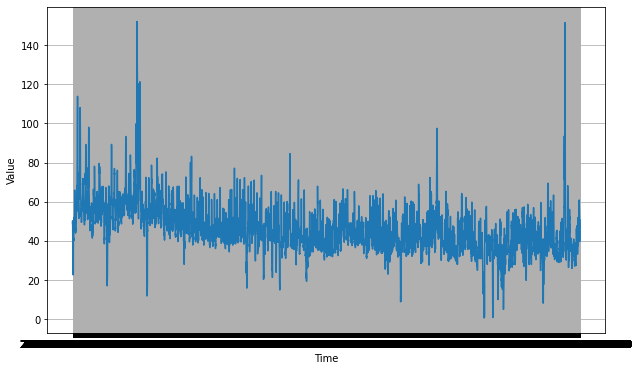

In [16]:
import csv
time_step = []
elec_prices = []

with open('small_elec.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    elec_prices.append(float(row[1]))
    time_step.append(str(row[0]))

series = np.array(elec_prices)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 7810 # Train 01 -01 -2019 test: 15 -06 -2019
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 10000

In [18]:
time_train

array(['2019-01-01 00:00:00', '2019-01-01 00:30:00',
       '2019-01-01 01:00:00', ..., '2019-06-14 22:30:00',
       '2019-06-14 23:00:00', '2019-06-14 23:30:00'], dtype='<U19')

In [19]:
len(series)

8530

# 1. Simple RNN Model:

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=43, callbacks=[lr_schedule])

Epoch 1/43
61/61 [==============================] - 4s 65ms/step - loss: 205.2500 - mae: 205.7639
Epoch 2/43
61/61 [==============================] - 3s 46ms/step - loss: 192.6193 - mae: 193.1426
Epoch 3/43
61/61 [==============================] - 3s 46ms/step - loss: 176.1388 - mae: 176.6761
Epoch 4/43
61/61 [==============================] - 3s 46ms/step - loss: 153.4064 - mae: 153.9575
Epoch 5/43
61/61 [==============================] - 3s 45ms/step - loss: 117.6216 - mae: 118.2066
Epoch 6/43
61/61 [==============================] - 3s 45ms/step - loss: 57.6880 - mae: 58.2947
Epoch 7/43
61/61 [==============================] - 3s 46ms/step - loss: 17.6531 - mae: 18.1662
Epoch 8/43
61/61 [==============================] - 3s 46ms/step - loss: 13.5416 - mae: 14.0284
Epoch 9/43
61/61 [==============================] - 3s 48ms/step - loss: 11.1709 - mae: 11.6631
Epoch 10/43
61/61 [==============================] - 3s 50ms/step - loss: 8.5040 - mae: 8.9973
Epoch 11/43
61/61 [============

(1e-08, 0.0001, 0.0, 60.0)

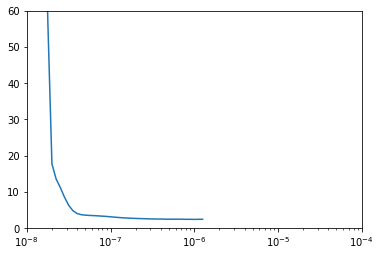

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

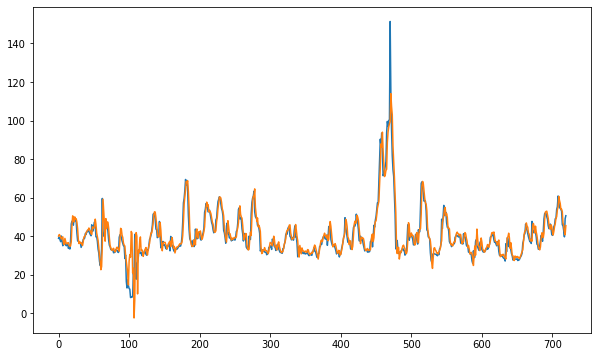

In [0]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


#plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, results)
from matplotlib import pyplot
pyplot.figure(figsize=(10, 6))
pyplot.plot( x_valid)
pyplot.plot(results)
pyplot.show()

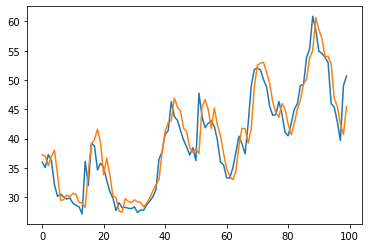

In [0]:
pyplot.plot(x_valid[-100:])
pyplot.plot(results[-100:])
pyplot.show()

In [0]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, results)
error2 = rmse(x_valid, results)
error3 = mean_absolute_error(x_valid, results)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(results)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error4 = mean_absolute_percentage_error(x_valid, results)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 3.129019217
MSE Error : 28.26239083
RMSE Error:  5.31623841
MAPE Error: 9.371776685


# 2. The model with LSTM + convolutional layer on top

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None,1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=70)

Epoch 1/70
78/78 [==============================] - 5s 60ms/step - loss: 8.6142 - mae: 9.1220
Epoch 2/70
78/78 [==============================] - 2s 22ms/step - loss: 4.1443 - mae: 4.6065
Epoch 3/70
78/78 [==============================] - 2s 21ms/step - loss: 3.7393 - mae: 4.2001
Epoch 4/70
78/78 [==============================] - 2s 21ms/step - loss: 3.4849 - mae: 3.9414
Epoch 5/70
78/78 [==============================] - 2s 22ms/step - loss: 3.2928 - mae: 3.7482
Epoch 6/70
78/78 [==============================] - 2s 21ms/step - loss: 3.1358 - mae: 3.5902
Epoch 7/70
78/78 [==============================] - 2s 21ms/step - loss: 3.0001 - mae: 3.4525
Epoch 8/70
78/78 [==============================] - 2s 23ms/step - loss: 2.8906 - mae: 3.3415
Epoch 9/70
78/78 [==============================] - 2s 22ms/step - loss: 2.7915 - mae: 3.2378
Epoch 10/70
78/78 [==============================] - 2s 22ms/step - loss: 2.6531 - mae: 3.0975
Epoch 11/70
78/78 [==============================] - 2s 21m

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
#plt.figure(figsize=(10, 6))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, rnn_forecast)

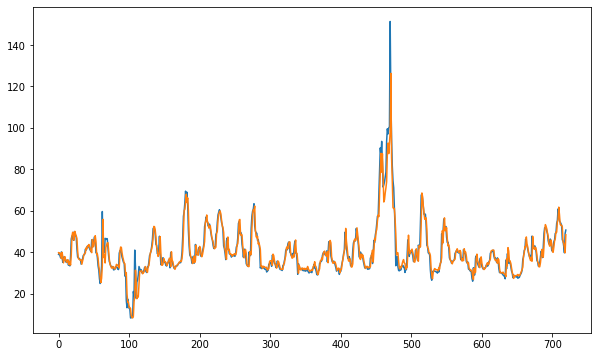

In [0]:
pyplot.figure(figsize=(10, 6))
pyplot.plot( x_valid)
pyplot.plot(rnn_forecast)
pyplot.show()


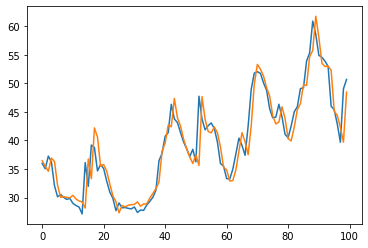

In [0]:
pyplot.plot(x_valid[-100:])
pyplot.plot(rnn_forecast[-100:])
pyplot.show()

In [0]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, rnn_forecast)
error2 = rmse(x_valid, rnn_forecast)
error3 = mean_absolute_error(x_valid, rnn_forecast)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(rnn_forecast)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error4 = mean_absolute_percentage_error(x_valid, rnn_forecast)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')


MAE Error: 2.466151943
MSE Error : 18.36779643
RMSE Error: 4.285766726
MAPE Error: 6.017219084


<Figure size 432x288 with 0 Axes>

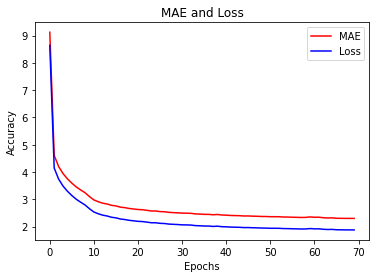

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.figure()


# 3. The model with only LSTM:

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [21]:

tf.keras.backend.clear_session()
tf.compat.v2.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=60, callbacks=[lr_schedule])

Epoch 1/60
244/244 [==============================] - 8s 32ms/step - loss: 16.8610 - mae: 17.3707
Epoch 2/60
244/244 [==============================] - 3s 13ms/step - loss: 11.3207 - mae: 11.8217
Epoch 3/60
244/244 [==============================] - 3s 13ms/step - loss: 9.5324 - mae: 10.0004
Epoch 4/60
244/244 [==============================] - 3s 13ms/step - loss: 8.7999 - mae: 9.3052
Epoch 5/60
244/244 [==============================] - 3s 13ms/step - loss: 8.5293 - mae: 9.0248
Epoch 6/60
244/244 [==============================] - 3s 13ms/step - loss: 8.3931 - mae: 8.8821
Epoch 7/60
244/244 [==============================] - 3s 13ms/step - loss: 8.2997 - mae: 8.7890
Epoch 8/60
244/244 [==============================] - 3s 13ms/step - loss: 8.2042 - mae: 8.7068
Epoch 9/60
244/244 [==============================] - 3s 13ms/step - loss: 8.1418 - mae: 8.6433
Epoch 10/60
244/244 [==============================] - 3s 13ms/step - loss: 8.1284 - mae: 8.5851
Epoch 11/60
244/244 [=============

(1e-08, 0.0001, 0.0, 30.0)

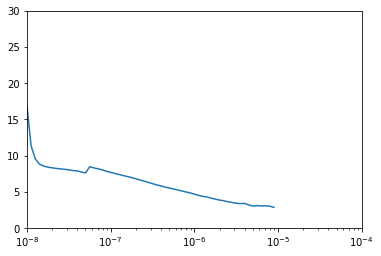

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [0]:
forecast = []
res = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
res = np.array(forecast)[:, 0, 0]


#plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, results)



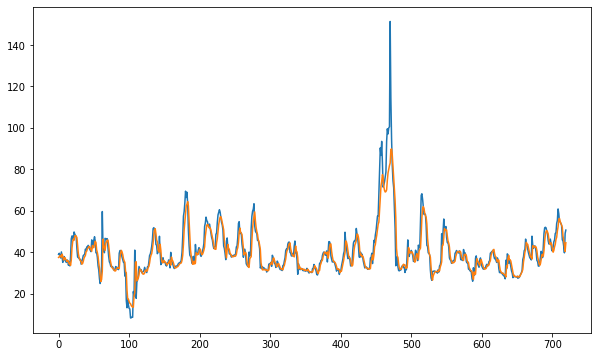

In [30]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 6))
pyplot.plot( x_valid)
pyplot.plot(res)
pyplot.show()


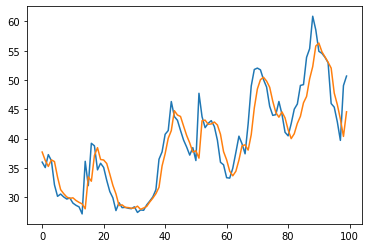

In [35]:
pyplot.plot(x_valid[-100:])
pyplot.plot(res[-100:])
pyplot.show()

In [36]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse,rmse
error1 = mse(x_valid, res)
error2 = rmse(x_valid, res)
error3 = mean_absolute_error(x_valid, res)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(x_valid), np.array(res)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
error4 = mean_absolute_percentage_error(x_valid, res)

print(f'MAE Error: {error3:11.10}') 
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print(f'MAPE Error: {error4:11.10}')

MAE Error: 2.970674384
MSE Error :   28.724103
RMSE Error: 5.359487195
MAPE Error: 7.117049726


<Figure size 432x288 with 0 Axes>

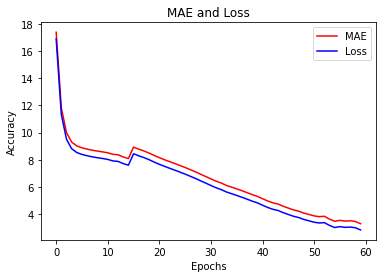

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

plt.figure()